<a href="https://colab.research.google.com/github/rfarwell/MPhys/blob/main/AugmentationVisualisation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This code will allow for the visualisation of augmentations.

Importing relevant libraries (note that not all of these will be necessary, they are just copied from the full CNN code)

In [ ]:
!pip install torch torchvision
!pip install opencv-contrib-python
!pip install scikit-learn
!pip install SimpleITK

import numpy as np
import random
import os
import matplotlib.pyplot as plt
import SimpleITK as sitk
import torch

from mpl_toolkits.mplot3d import Axes3D
from torch.nn import Module
from torch.nn import Conv3d
from torch.nn import Linear
from torch.nn import MaxPool2d
from torch.nn import ReLU
from torch.nn import LogSoftmax
from torch import flatten
from torch import nn
from torch import reshape
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision import datasets
from torch.optim import Adam
import torchvision.models as models
from torch.autograd import Variable
from torch.utils.tensorboard import SummaryWriter
from scipy.ndimage import zoom, rotate

tb = SummaryWriter()

Mount to GoogleDrive and 'cd' to the relevant folder.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/MyDrive/

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive


Connect to a GPU if it is available and define the file path to the metadata file

In [ ]:
# Connect to GPU is available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')
# /content/gdrive/MyDrive/MPhys/Data/COLAB-Clinical-Data.csv
# Specify project folder location
project_folder = "/content/gdrive/MyDrive/Data"
clinical_data_filename = "NSCLC-Radiomics-Clinical-Data.csv"
print(os.path.join(project_folder, clinical_data_filename))

Using cpu device
/content/gdrive/MyDrive/Data/NSCLC-Radiomics-Clinical-Data.csv


Open metadata file

In [ ]:
metadata_file = os.path.join(project_folder, clinical_data_filename)
print(f'metadata_file path: {metadata_file}')
metadata = np.genfromtxt(metadata_file, comments = '%', dtype="str", delimiter=",")
print(f"Length of metadata array is {len(metadata)}")

metadata_file path: /content/gdrive/MyDrive/Data/NSCLC-Radiomics-Clinical-Data.csv
Length of metadata array is 400


Creating array that will be used to bring in the relevant CT images ready for the visualisation of augmentation

Defining transforms and image dataset classes. Also define window and levelling function (normalisation included in this).

['LUNG1-069']
[1]
[('LUNG1-069', 1)]
[('LUNG1-069', 1)]
Left-right flip applied
0.21733333
264


(0.0, 264.0)

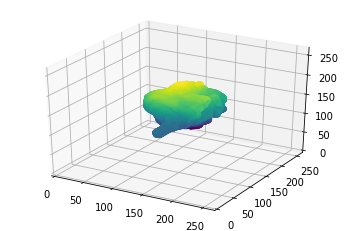

In [ ]:
########################### CREATING ARRAYS FOR PATIENT ID AND DEAD STATUS ################################# 
patient_IDs = np.array(metadata[:,0])
#print(patient_IDs)
shortened_patient_IDs = patient_IDs[63:64] # Choosing which patient data to load for the augmentation visualisation
print(shortened_patient_IDs)

dead_statuses = np.array(metadata[:,9], dtype = np.int32)
shortened_dead_statuses = dead_statuses[63:64] # This slice should be the same as the one above
print(shortened_dead_statuses)

total_array = []

for i in range(len(shortened_patient_IDs)) :
  total_array.append((shortened_patient_IDs[i], shortened_dead_statuses[i]))

print(total_array)
############################################################################################################

def window_and_level(image, level = -600, window = 1500) :
  maxval = level + window/2
  minval = level - window/2
  wld = np.clip(image, minval, maxval)
  wld -=minval
  wld *= 1/window
  return wld

transform = transforms.Compose(
    [transforms.ToTensor()]
)

######################################## CREATING IMAGE DATASET CLASS ######################################
"""
This includes 4 augmentations that can be applied: Shift, rotation, scaling, flip l-r.

"""
class ImageDataset(Dataset) :
  def __init__(self, annotations, img_dir, transform = transform, target_transform = None, shift_augment = True, rotate_augment = True, scale_augment = True, flip_augment = True) :
    self.img_labels = annotations
    self.img_dir = img_dir
    self.transform = transform
    self.target_transform = target_transform
    self.shifts = shift_augment
    self.rotations = rotate_augment
    self.flips = flip_augment
    self.scales = scale_augment
    print(self.img_labels)

  def __len__(self) :
    return len(self.img_labels)

  def __getitem__(self,idx) :
    img_path = os.path.join(self.img_dir, self.img_labels[idx][0] + "-GTV-1.nii" )
    image_sitk = sitk.ReadImage(img_path)
    # ID = self.img_labels[idx][0]
    # print(f'ID: {ID}')
    image = sitk.GetArrayFromImage(image_sitk)
    label = self.img_labels[idx][1]

    # Augmentations
    if self.shifts:
      mx_x, mx_yz = 10, 10 
      # find shift values
      cc_shift, ap_shift, lr_shift = random.randint(-mx_x,mx_x), random.randint(-mx_yz,mx_yz), random.randint(-mx_yz,mx_yz)
      # pad for shifting into
      image = np.pad(image, pad_width=((mx_x,mx_x),(mx_yz,mx_yz),(mx_yz,mx_yz)), mode='constant', constant_values=-1024) # original is zero but appears to work better with -1024 (HU of air)
      # crop to complete shift
      image = image[mx_x+cc_shift:264+mx_x+cc_shift, mx_yz+ap_shift:264+mx_yz+ap_shift, mx_yz+lr_shift:264+mx_yz+lr_shift]

    if self.rotations and random.random() < 0.5 : # normal is 0.5
      roll_angle = np.clip(np.random.normal(loc=0,scale=3), -15, 15)
      print(f'Rotation by angle {roll_angle} applied.')
      #print(roll_angle)
      image = self.rotation(image, roll_angle, rotation_plane=(1,2))

    if self.scales and random.random() < 0.5 : # normal is 0.5
      # same here -> zoom between 80-120%
      scale_factor = np.clip(np.random.normal(loc=1.0,scale=0.05), 0.7, 1.3)
      print(f'Scaled by factor {scale_factor}.')
      image = self.scale(image, scale_factor)
    
    if self.flips and random.random() < 0.5 : # normal is 0.5
        print(f'Left-right flip applied')
        image = np.flipud(image)
    
    image = window_and_level(image)

    if self.transform :
      image = self.transform(image)
    if self.target_transform :
      label = self.target_transform(label)
    return image,label
  
  def rotation(self, image, rotation_angle, rotation_plane):
      # rotate the image or mask using scipy rotate function
      order, cval = (3, -1024)
      return rotate(input=image, angle=rotation_angle, axes=rotation_plane, reshape=False, order=order, mode='constant', cval=cval)
    
  def scale(self, image, scale_factor):
      # scale the image or mask using scipy zoom function
      order, cval = (3, -1024)
      height, width, depth = image.shape
      zheight = int(np.round(scale_factor*height))
      zwidth = int(np.round(scale_factor*width))
      zdepth = int(np.round(scale_factor*depth))
      # zoomed out
      if scale_factor < 1.0:
          new_image = np.full_like(image, cval)
          ud_buffer = (height-zheight) // 2
          ap_buffer = (width-zwidth) // 2
          lr_buffer = (depth-zdepth) // 2
          new_image[ud_buffer:ud_buffer+zheight, ap_buffer:ap_buffer+zwidth, lr_buffer:lr_buffer+zdepth] = zoom(input=image, zoom=scale_factor, order=order, mode='constant', cval=cval)[0:zheight, 0:zwidth, 0:zdepth]
          return new_image
      elif scale_factor > 1.0:
          new_image = zoom(input=image, zoom=scale_factor, order=order, mode='constant', cval=cval)[0:zheight, 0:zwidth, 0:zdepth]
          ud_extra = (new_image.shape[0] - height) // 2
          ap_extra = (new_image.shape[1] - width) // 2
          lr_extra = (new_image.shape[2] - depth) // 2
          new_image = new_image[ud_extra:ud_extra+height, ap_extra:ap_extra+width, lr_extra:lr_extra+depth]
          return new_image
      return image
############################################################################################################
test_data = ImageDataset(total_array, os.path.join(project_folder, "Textured_Masks"), transform = transforms.ToTensor())
test_dataloader = DataLoader(test_data, batch_size = 4, shuffle = False)

data = next(iter(test_dataloader))
#print(data[0][0].numpy())
array = data[0][0].numpy()
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
print(array[0][0][0])

x,y,z = np.where(array > array[0][0][0])
#x,y,z = np.where(array > 0.9)
ax.scatter(x, y, z, c=z, alpha=1)
#ax.contour3D(x,y,z,50, cmap = 'binary')
print(len(array))
#ax.view_init(20, 0)

ax.set_xlim(0,len(array))
ax.set_ylim(0,len(array))
ax.set_zlim(0,len(array))